In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import mixture
from sklearn.decomposition import PCA
import time
import sys
import scipy.ndimage
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
#%matplotlib notebook
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
import warnings
warnings.filterwarnings(action='once')

In [2]:
def classify1(features, MX, stop_imm = True, tp = 'full'):
    newdata = features
    n_components = np.arange(1, MX + 1)
    BIC = np.zeros(n_components.shape)
    lowest_bic = np.infty
    best_gmm = None

    for i, n in enumerate(n_components):        
        gmm = GaussianMixture(n_components=n, covariance_type=tp, random_state=0)
        gmm.fit(newdata)
        BIC[i] = gmm.bic(newdata)
        dbic = np.abs(BIC[i] - lowest_bic) / np.abs(BIC[i])
        print(n, BIC[i], dbic)
        if BIC[i] < lowest_bic:
        #if dbic >= 1e-3:        
            lowest_bic = BIC[i]
            best_gmm = gmm
        elif stop_imm:
            break

    best_gmm = GaussianMixture(n_components=best_gmm.n_components, covariance_type=tp, random_state=0)
    best_gmm.fit(features)

    print(best_gmm.n_components)
    plt.figure()
    plt.plot(BIC)
    plt.show()
    return best_gmm

from sklearn.metrics.scorer import make_scorer

def my_scorer(clf, X):
    return -clf.bic(X)

def classify4(features):
    parameters = {
        'n_components' : np.arange(1, 15)
    }
    #clf = GridSearchCV(GaussianMixture(covariance_type='full'), parameters, cv=5, n_jobs=-1, scoring=my_scorer)
    clf = GridSearchCV(GaussianMixture(covariance_type='full'), parameters, cv=5, n_jobs=-1)
    clf.fit(features)
    print("n_components",clf.best_estimator_.n_components)
    return clf.best_estimator_

def plot_array(arr):
    ny, nx = arr.shape
    xv, yv = np.meshgrid(np.linspace(0, nx, nx), np.linspace(0, ny, ny))
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(xv,yv,arr)
    plt.show()

In [3]:
df = pd.read_csv("data_reception_long_train.csv")
df.drop([df.columns[0], "Rf"], inplace=True, axis=1)
scaler = MinMaxScaler((0, 10))
df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df.columns[2:])


#df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
#from sklearn.decomposition import PCA
#pca = PCA(0.99, whiten=True)
#df2 = pd.DataFrame(pca.fit_transform(df2))

#df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
#df2 = pd.DataFrame(df2, columns=df.columns[2:])


display(df2.describe())
display(df2.head(5))

,x,y,w,h,mx,my
count,185996.000000,185996.000000,185996.000000,185996.000000,185996.000000,185996.000000
mean,7.856221,4.354679,2.178752,2.980378,4.859886,4.475732
std,1.896139,1.554093,1.043240,1.857733,0.257863,0.157898
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.920583,3.215859,1.510791,1.627907,4.861111,4.473684
50%,8.298217,3.942731,1.942446,2.093023,4.861111,4.473684
75%,9.254457,5.110132,2.661871,4.031008,4.861111,4.473684
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


,x,y,w,h,mx,my
0,6.693679,1.607930,2.446043,4.961240,4.861111,4.473684
1,8.168558,3.039648,3.669065,3.333333,4.861111,4.473684
2,6.693679,1.607930,2.446043,4.961240,4.861111,4.473684
3,8.168558,3.039648,3.669065,3.333333,4.861111,4.473684
4,6.693679,1.607930,2.446043,4.961240,4.861111,4.473684


In [4]:
#bgmm = classify1(df2, 19, True)
bgmm = classify4(df2)

n_components 13


In [5]:
def extend_set(df):
    df_tmp = df[["time", "frame"]].groupby(['time', 'frame']).agg('count')
    df_tmp.reset_index(inplace=True)

    first_time = df_tmp.iloc[0]["time"] 
    first_frame = df_tmp.iloc[0]["frame"]

    last_time = df_tmp.iloc[len(df_tmp) - 1]["time"]
    last_frame = df_tmp.iloc[len(df_tmp) - 1]["frame"]

    dt_time = df_tmp.iloc[len(df_tmp) - 1]["time"] - df_tmp.iloc[len(df_tmp) - 2]["time"]
    dt_frame = df_tmp.iloc[len(df_tmp) - 1]["frame"] - df_tmp.iloc[len(df_tmp) - 2]["frame"]

    df_app = df.apply(lambda x: [x['time'] - first_time + last_time + dt_time, x['frame'] - first_frame + last_frame + dt_frame] + list(x[2:]), axis=1)
    df_app = df.append(df_app)
    df_app.reset_index(inplace=True, drop=True)
    return df_app
#df = extend_set(df)
#df = extend_set(df)
#df = extend_set(df)

#df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
#df2 = pd.DataFrame(scaler.transform(df2), columns=df.columns[2:])

In [6]:
df3 = pd.DataFrame(bgmm.predict_proba(df2))
df3["time"] = df["time"]
df3["frame"] = df["frame"]
df3 = df3.groupby(['time', 'frame']).agg('max')
df3.reset_index(inplace=True)

#display(df3.head(11))

#df3 = df3.apply(lambda x: [x['time'], x['frame']] + list(x[2:] / x[2:].sum()), axis=1)
#df3_test = df3_test.apply(lambda x: [x['time'], x['frame']] + list(x[2:] / x[2:].sum()), axis=1)

display(df3.head(11))

#arr = df3_test.drop(["frame", "time"], axis=1)
#display(np.array(arr))
#display(np.array(arr) / np.linalg.norm(arr, axis=1))

PN = []

last_t = df3.iloc[0]["time"]

pn = []

seg_len = 15
seg_n_len = 15
seg_max_delay = 1.0

i = 0
i_next = 0
i_next_tm = 0
while i < len(df3) - 1:
    r = df3.iloc[i]            
    pn.append(r.drop(["time", "frame"]).ravel())
    
    if (df3.iloc[i + 1].time - df3.iloc[i].time > seg_max_delay):
        print("seg brk at",i)
        i_next = i + 1
        i_next_tm = df3.iloc[i + 1].time
        last_t = -10000
    elif (i_next == 0) and (r.time - last_t > seg_n_len):
        i_next = i + 1
        i_next_tm = df3.iloc[i + 1].time
    if r.time - last_t > seg_len:
        last_t = i_next_tm
        i = i_next
        i_next = 0
        if len(pn) >= bgmm.n_components:
            PN.append(pn)
        else:
            print("too short", len(pn))
        pn = []
    else:
        i += 1

#display(PN[0])        
        
print("N =",len(PN))
for i in range(len(PN)):
    print("N[",i,"]=",len(PN[i]))

,time,frame,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2.56,64,2.342423e-135,0.947719,0.995728,2.875668e-60,9.693679e-12,2.260575e-09,0.001243,0.000067,1.996655e-113,0,1.295720e-07,0,2.173904e-281
1,2.68,67,2.342423e-135,0.947719,0.995728,2.875668e-60,9.693679e-12,2.260575e-09,0.001243,0.000067,1.996655e-113,0,1.295720e-07,0,2.173904e-281
2,2.80,70,2.342423e-135,0.947719,0.995728,2.875668e-60,9.693679e-12,2.260575e-09,0.001243,0.000067,1.996655e-113,0,1.295720e-07,0,2.173904e-281
3,2.92,73,2.342423e-135,0.947719,0.995728,2.875668e-60,9.693679e-12,2.260575e-09,0.001243,0.000067,1.996655e-113,0,1.295720e-07,0,2.173904e-281
4,3.04,76,0.000000e+00,0.000000,0.000000,0.000000e+00,2.594051e-09,2.319987e-09,0.845974,0.100271,0.000000e+00,0,5.375424e-02,0,0.000000e+00
5,3.16,79,0.000000e+00,0.000000,0.000000,0.000000e+00,2.705654e-09,1.613090e-09,0.876323,0.082204,0.000000e+00,0,4.147306e-02,0,0.000000e+00
6,3.28,82,1.556690e-253,0.957312,0.042537,9.520364e-87,2.708585e-13,1.112132e-13,0.000142,0.000006,2.072981e-238,0,2.931570e-06,0,0.000000e+00
7,3.40,85,0.000000e+00,0.000000,0.000000,0.000000e+00,2.231322e-09,8.886748e-10,0.941127,0.045407,0.000000e+00,0,1.346541e-02,0,0.000000e+00
8,3.52,88,0.000000e+00,0.000000,0.000000,0.000000e+00,2.705525e-08,3.577866e-12,0.975990,0.023583,0.000000e+00,0,4.272279e-04,0,0.000000e+00
9,3.64,91,0.000000e+00,0.000000,0.981447,0.000000e+00,3.264978e-10,2.336291e-14,0.018341,0.000210,0.000000e+00,0,1.576661e-06,0,0.000000e+00


seg brk at 23
seg brk at 59
seg brk at 67
too short 8
seg brk at 75
too short 8
seg brk at 79
too short 4
seg brk at 99
seg brk at 103
too short 4
seg brk at 107
too short 4
seg brk at 155
seg brk at 159
too short 4
seg brk at 251
seg brk at 375
too short 1
seg brk at 423
seg brk at 467
seg brk at 511
seg brk at 515
too short 4
seg brk at 523
too short 8
seg brk at 531
too short 8
seg brk at 535
too short 4
seg brk at 555
seg brk at 615
seg brk at 619
too short 4
seg brk at 643
seg brk at 647
too short 4
seg brk at 679
seg brk at 695
seg brk at 699
too short 4
seg brk at 703
too short 4
seg brk at 707
too short 4
seg brk at 715
too short 8
seg brk at 719
too short 4
seg brk at 723
too short 4
seg brk at 779
seg brk at 987
seg brk at 999
too short 12
seg brk at 1003
too short 4
seg brk at 1007
too short 4
seg brk at 1039
seg brk at 1151
seg brk at 1155
too short 4
seg brk at 1207
seg brk at 1299
seg brk at 1303
too short 4
seg brk at 1327
seg brk at 1339
too short 12
seg brk at 1343
too

seg brk at 17659
seg brk at 17683
seg brk at 18071
too short 11
seg brk at 18147
seg brk at 18151
too short 4
seg brk at 18195
seg brk at 18203
too short 8
seg brk at 18263
seg brk at 18575
seg brk at 18619
seg brk at 18635
seg brk at 19191
seg brk at 19215
seg brk at 19243
seg brk at 19339
seg brk at 19347
too short 8
seg brk at 19531
seg brk at 19571
seg brk at 19579
too short 8
seg brk at 19615
seg brk at 19619
too short 4
seg brk at 19627
too short 8
seg brk at 19631
too short 4
seg brk at 19635
too short 4
seg brk at 19643
too short 8
seg brk at 19647
too short 4
seg brk at 19663
seg brk at 19671
too short 8
seg brk at 19679
too short 8
seg brk at 19691
too short 12
seg brk at 19715
seg brk at 19719
too short 4
seg brk at 19823
seg brk at 19863
seg brk at 19871
too short 8
seg brk at 19931
seg brk at 20047
seg brk at 20067
seg brk at 20071
too short 4
seg brk at 20075
too short 4
seg brk at 20315
seg brk at 20319
too short 4
seg brk at 20327
too short 8
seg brk at 20331
too short 

seg brk at 37079
too short 10
seg brk at 37143
seg brk at 37647
seg brk at 37671
seg brk at 37727
seg brk at 37731
too short 4
seg brk at 37735
too short 4
seg brk at 37739
too short 4
seg brk at 37747
too short 8
seg brk at 37779
seg brk at 37879
seg brk at 37935
seg brk at 37959
seg brk at 38643
seg brk at 38655
too short 12
seg brk at 38707
seg brk at 38755
seg brk at 38791
seg brk at 38819
seg brk at 38831
too short 12
seg brk at 38847
seg brk at 38931
seg brk at 38943
too short 12
seg brk at 38955
too short 12
seg brk at 38967
too short 12
seg brk at 38975
too short 8
seg brk at 38979
too short 4
seg brk at 39115
seg brk at 39147
seg brk at 39199
seg brk at 39219
seg brk at 39235
seg brk at 39447
seg brk at 39451
too short 4
seg brk at 39567
seg brk at 39571
too short 4
seg brk at 39575
too short 4
seg brk at 39627
seg brk at 39791
seg brk at 39819
seg brk at 39995
seg brk at 40003
too short 8
seg brk at 40019
seg brk at 40047
seg brk at 40151
seg brk at 40179
seg brk at 40191
too

seg brk at 61235
seg brk at 61239
too short 4
seg brk at 61571
seg brk at 61595
seg brk at 61623
seg brk at 61631
too short 8
seg brk at 61651
seg brk at 61655
too short 4
seg brk at 61659
too short 4
seg brk at 61663
too short 4
seg brk at 62319
seg brk at 62379
seg brk at 63027
seg brk at 63063
seg brk at 63067
too short 4
seg brk at 63071
too short 4
seg brk at 63075
too short 4
seg brk at 63079
too short 4
seg brk at 63087
too short 8
seg brk at 63099
too short 12
seg brk at 63111
too short 12
seg brk at 63115
too short 4
seg brk at 63119
too short 4
seg brk at 63203
seg brk at 63227
seg brk at 63235
too short 8
seg brk at 63243
too short 8
seg brk at 63251
too short 8
seg brk at 63343
seg brk at 63435
seg brk at 63463
seg brk at 63475
too short 12
seg brk at 63479
too short 4
seg brk at 63551
seg brk at 63615
seg brk at 63631
seg brk at 63671
seg brk at 63675
too short 4
seg brk at 63679
too short 4
seg brk at 63683
too short 4
seg brk at 63687
too short 4
seg brk at 63703
seg brk

N[ 825 ]= 48
N[ 826 ]= 127
N[ 827 ]= 65
N[ 828 ]= 119
N[ 829 ]= 37
N[ 830 ]= 127
N[ 831 ]= 61
N[ 832 ]= 48
N[ 833 ]= 127
N[ 834 ]= 127
N[ 835 ]= 127
N[ 836 ]= 43
N[ 837 ]= 64
N[ 838 ]= 48
N[ 839 ]= 32
N[ 840 ]= 48
N[ 841 ]= 36
N[ 842 ]= 127
N[ 843 ]= 53
N[ 844 ]= 76
N[ 845 ]= 40
N[ 846 ]= 16
N[ 847 ]= 56
N[ 848 ]= 92
N[ 849 ]= 92
N[ 850 ]= 28
N[ 851 ]= 20
N[ 852 ]= 52
N[ 853 ]= 72
N[ 854 ]= 64
N[ 855 ]= 40
N[ 856 ]= 40
N[ 857 ]= 24
N[ 858 ]= 107
N[ 859 ]= 127
N[ 860 ]= 127
N[ 861 ]= 127
N[ 862 ]= 56
N[ 863 ]= 52
N[ 864 ]= 32
N[ 865 ]= 127
N[ 866 ]= 123
N[ 867 ]= 127
N[ 868 ]= 127
N[ 869 ]= 25
N[ 870 ]= 68
N[ 871 ]= 127
N[ 872 ]= 97
N[ 873 ]= 127
N[ 874 ]= 101
N[ 875 ]= 127
N[ 876 ]= 126
N[ 877 ]= 127
N[ 878 ]= 115
N[ 879 ]= 127
N[ 880 ]= 14
N[ 881 ]= 127
N[ 882 ]= 119
N[ 883 ]= 114
N[ 884 ]= 24
N[ 885 ]= 16
N[ 886 ]= 20
N[ 887 ]= 111
N[ 888 ]= 93
N[ 889 ]= 80
N[ 890 ]= 60
N[ 891 ]= 104
N[ 892 ]= 20
N[ 893 ]= 116
N[ 894 ]= 28
N[ 895 ]= 123
N[ 896 ]= 123
N[ 897 ]= 123
N[ 898 ]= 48
N[ 899

In [7]:
from hmmlearn import hmm

hmms1 = []

N = len(PN)

for i in range(N):    
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag")
    hmm1.fit(PN[i])
    assert(hmm1.monitor_.converged)
    hmms1.append(hmm1)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  a_lse = logsumexp(a, axis)


In [8]:
import threading

Sij = np.zeros((N,N), np.float64)

hmm_scores = {}

def hmm_thread(idx):
    for i in idx:
        for j in range(N):                
            if (i, j) in hmm_scores:
                scr1 = hmm_scores[(i, j)]
            else:
                scr1 = hmm_scores[(i, j)] = hmms1[i].score(PN[j])

            if (j, i) in hmm_scores:
                scr2 = hmm_scores[(j, i)]
            else:
                scr2 = hmm_scores[(j, i)] = hmms1[j].score(PN[i])
                            
            s1 = scr1 * (1.0 / len(PN[j]))
            s2 = scr2 * (1.0 / len(PN[i]))
            Sij[i, j] = 0.5 * (s1 + s2)
            assert(not np.isnan(Sij[i, j]))
            assert(not np.isinf(Sij[i, j]))

num_threads = 7

idx_split = np.array_split(range(N), num_threads)

thrs = []
for i in range(num_threads):
    thr = threading.Thread(target=hmm_thread, args=(idx_split[i],))    
    thr.start()
    thrs.append(thr)

for thr in thrs:
    thr.join()

/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


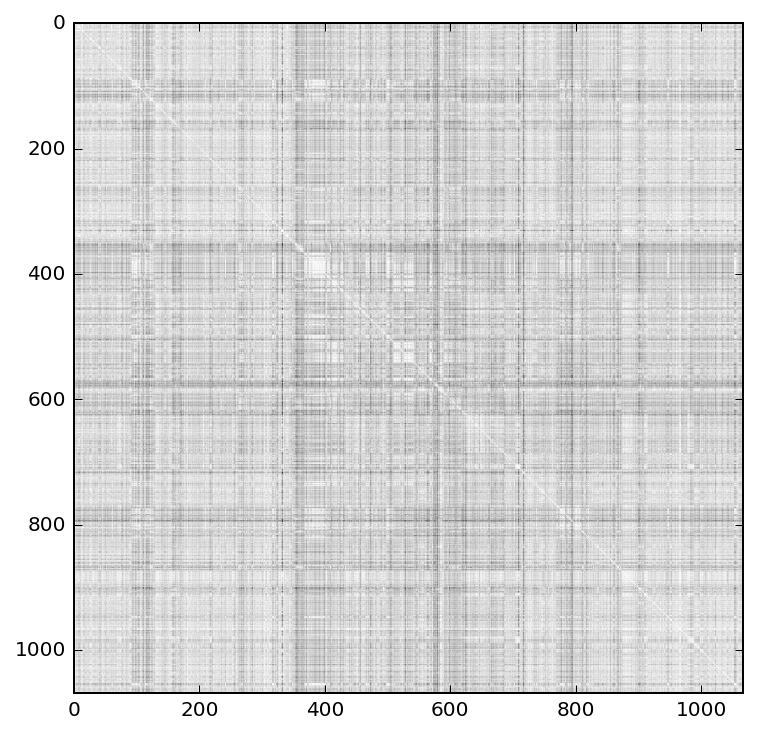

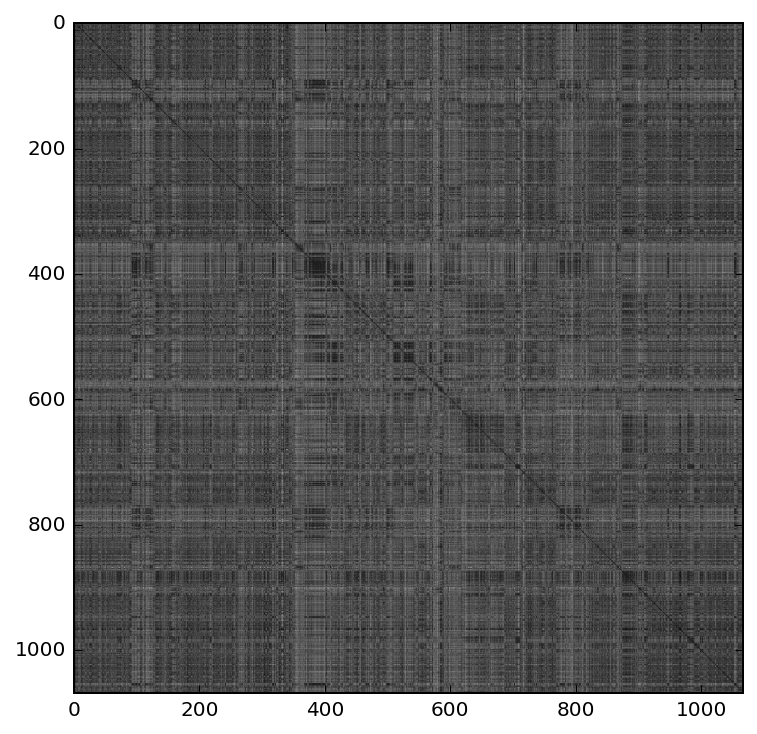

In [9]:
from scipy.linalg import fractional_matrix_power

Lij = np.zeros((N,N), np.float64)

for i in range(N):
    s1 = 0    
    for j in range(N):        
        s1 += Sij[i, j]
    Lij[i, i] = s1
Lij2 = fractional_matrix_power(Lij, -0.5)
Snorm = np.dot(np.dot(Lij2, Sij), Lij2).astype('float64')
#plot_array(Snorm)

plt.figure()
plt.imshow(Sij, cmap='gray')
plt.show()
plt.figure()
plt.imshow(Snorm, cmap='gray')
plt.show()

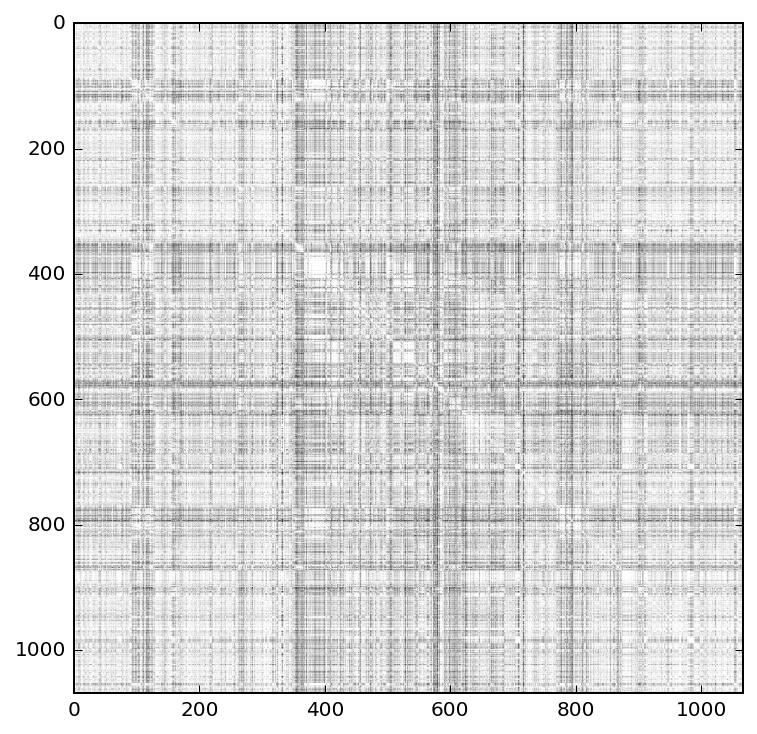

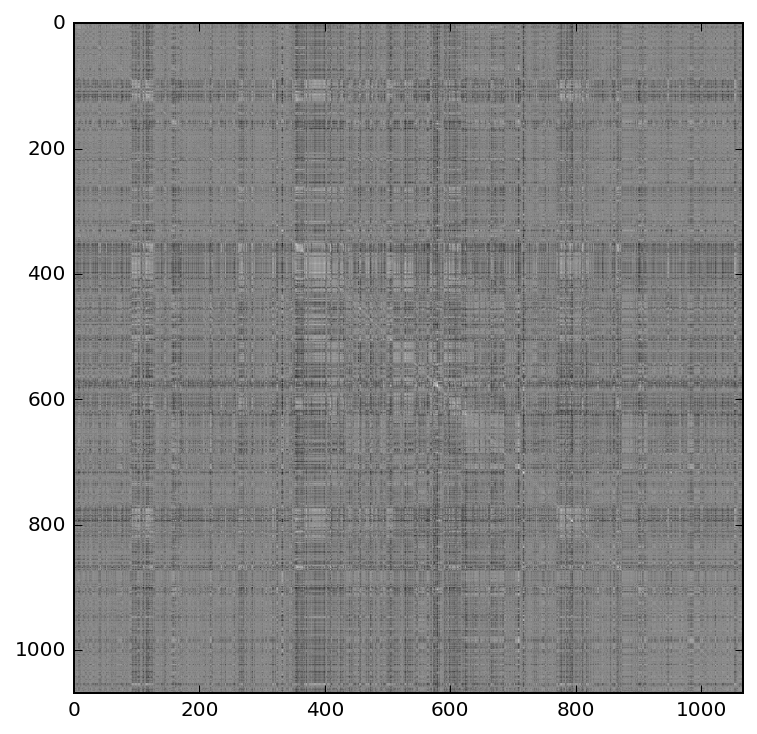

In [10]:
#Zelnik-Perona normalization, doesn't give us good results :(

Sij2 = np.zeros((N,N), np.float64)
        
sigmaK = np.zeros(Sij2.shape[0])
for i in range(Sij2.shape[0]):
    row = Sij[i, :]
    sigmaK[i] = np.sort(row)[6]
    #gm1 = GaussianMixture(n_components=1, covariance_type='diag')    
    #gm1.fit(row.reshape(-1, 1))
    #sigmaK[i] = gm1.covariances_[0][0]

for i in range(Sij2.shape[0]):
    for j in range(Sij2.shape[0]):
        Sij2[i,j] = np.exp((-1.0 * (Sij[i,j]**2.0)) / (sigmaK[i] * sigmaK[j]))
        
plt.figure()
plt.imshow(Sij2, cmap='gray')
plt.show()

D = np.diag(Sij2.sum(axis=1)**-0.5)
                
_L = np.dot(D,Sij2)
L = np.dot(_L,D)
Snorm = L

plt.figure()
plt.imshow(Snorm, cmap='gray')
plt.show()

Km= 20
(1068, 20)
0.999944171684
0.999934035559
0.545065414077
0.994003247219
0.971829304645
0.118736798542
0.480164044298
0.511208102676
0.098522151653
0.561109496621
0.450582918859
0.966432207318
0.516519783109
0.40193870029
0.300069350575
0.879586472037
0.806291659231
0.341944982239
0.9986958134
0.383484074756
New Km= 12
(1068, 12)
1 117720.616445 inf
2 115530.495891 0.0189570774089
3 114637.375798 0.00779082813955
4 113917.060449 0.00632315604463
5 113979.321186 0.000546245906491
6 113197.762613 0.00635434675129
7 113437.246021 0.00211115322577
8 114800.561681 0.0139615960441
9 114729.695381 0.0133525393079
10 115395.501686 0.0190452750777
11 115471.714296 0.0196927160622
12 116063.094233 0.0246877066215
6


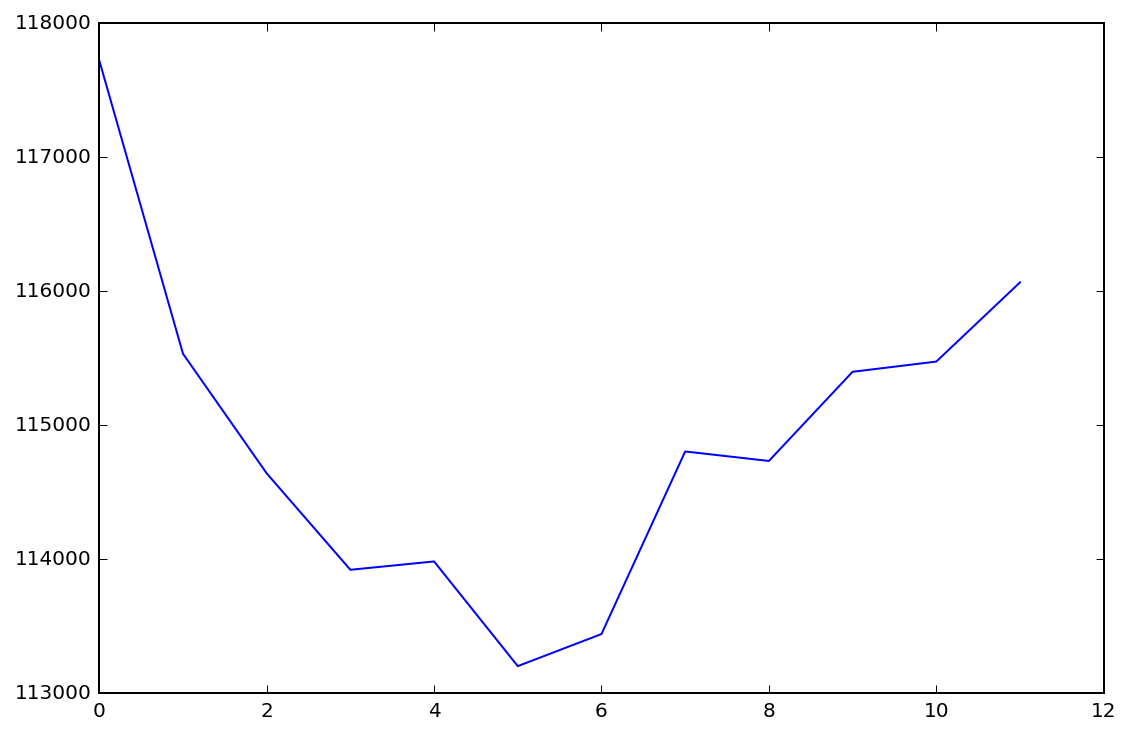

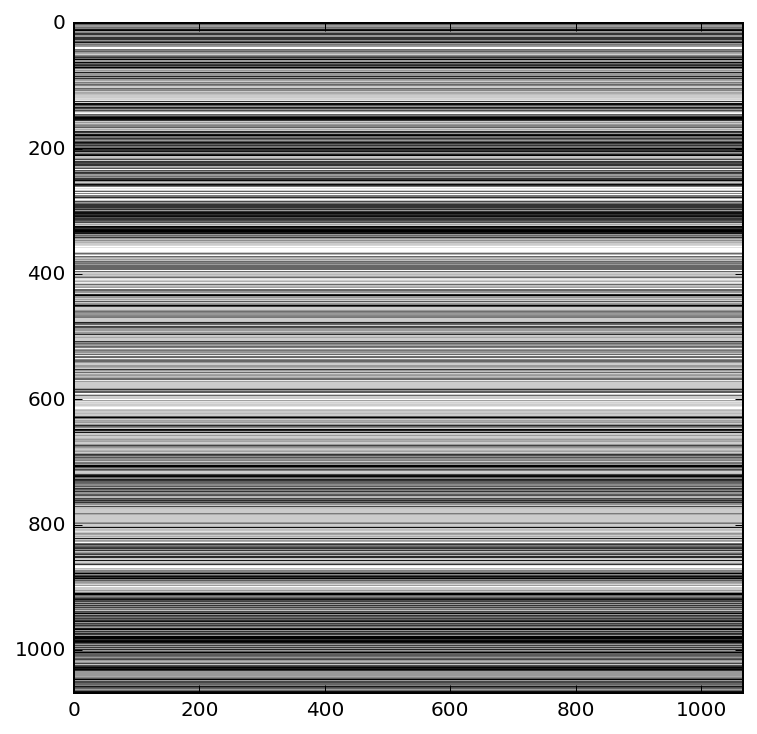

In [11]:
import mixem

Km = int(N / 5)
Km = np.min(np.array([Km, 20]))

Snorm_vals, Snorm_vecs = np.linalg.eigh(Sij)

Snorm_vecs = Snorm_vecs.T

for i in range(len(Snorm_vecs)):
    Snorm_vecs[i, :] *= Snorm_vals[i]
    #Snorm_vecs[i, :] *= 1000

indices = np.argsort(Snorm_vals)[::-1][:Km]
#indices = list(range(N-Km, N))[::-1]

top_vecs = Snorm_vecs[indices].T

assert(N == len(top_vecs))

print("Km=",Km)
print(top_vecs.shape)

def my_em(data, distributions, initial_weights=None, max_iterations=100, tol=1e-15, tol_iters=10, progress_callback=mixem.simple_progress):    
    n_distr = len(distributions)
    n_data = data.shape[0]

    if initial_weights is not None:
        weight = np.array(initial_weights)
    else:
        weight = np.ones((n_distr,))

    last_ll = np.zeros((tol_iters, ))
    resp = np.empty((n_data, n_distr))
    log_density = np.empty((n_data, n_distr))
    
    Rk = 0

    iteration = 0
    while True:
        # E-step #######

        # compute responsibilities
        for d in range(n_distr):
            log_density[:, d] = distributions[d].log_density(data)

        # normalize responsibilities of distributions so they sum up to one for example
        resp = weight[np.newaxis, :] * np.exp(log_density)
        resp /= np.sum(resp, axis=1)[:, np.newaxis]

        log_likelihood = np.sum(resp * log_density)

        # M-step #######
        h1 = resp[:, 0]
        h2 = resp[:, 1]
        h3 = resp[:, 2]
                                                
        for d in range(n_distr):            
            if d != 0:
                distributions[d].estimate_parameters(data, resp[:, d])
                distributions[d].sigma += 1e-6
                
        Rk = 1.0 - np.mean(h1)
        wk = np.mean(h2) / Rk
        
        weight[0] = 1.0 - Rk
        weight[1] = wk*Rk
        weight[2] = (1.0 - wk)*Rk
        
        assert(np.allclose(np.sum(weight), 1.0))

        if progress_callback:
            progress_callback(iteration, weight, distributions, log_likelihood)

        # Convergence check #######
        if np.isnan(log_likelihood):
            last_ll[0] = log_likelihood
            break

        if iteration >= tol_iters and np.abs(log_likelihood - last_ll[-1]) / np.abs(log_likelihood) <= tol:
            last_ll[0] = log_likelihood
            break

        if iteration >= max_iterations:
            last_ll[0] = log_likelihood
            break

        # store value of current iteration in last_ll[0]
        # and shift older values to the right
        last_ll[1:] = last_ll[:-1]
        last_ll[0] = log_likelihood

        iteration += 1

    return Rk, distributions, last_ll[0]

new_top_vecs = []
new_rks = []

for i in range(Km):
    mk1 = np.sum(top_vecs[:, i]) * (1.0 / N)
    sigma_k1 = np.sqrt(np.sum((top_vecs[:, i] - mk1) ** 2) * (1.0 / N))    
                            
    gm1 = GaussianMixture(n_components=1, covariance_type='diag', means_init=[[mk1]], precisions_init=[[1.0 / (sigma_k1 * sigma_k1)]])
    gm1.fit(top_vecs[:, i].reshape(-1, 1))
            
    dist0 = mixem.distribution.NormalDistribution(gm1.means_[0][0], np.sqrt(gm1.covariances_[0][0]))
                
    gm1 = GaussianMixture(n_components=2, covariance_type='diag')
    gm1.fit(top_vecs[:, i].reshape(-1, 1))
                    
    max_ds = [
        dist0,
        mixem.distribution.NormalDistribution(gm1.means_[0][0], np.sqrt(gm1.covariances_[0][0])),
        mixem.distribution.NormalDistribution(gm1.means_[1][0], np.sqrt(gm1.covariances_[1][0]))]
            
    max_ws = [0.5, gm1.weights_[0] * 0.5, gm1.weights_[1] * 0.5]
        
    Rk, ds, ll = my_em(top_vecs[:, i], max_ds,
        initial_weights = max_ws, progress_callback=None,
        tol_iters=100, max_iterations=10000, tol=1e-6)
        
    print(Rk)
    if (Rk >= 0.5):
        new_top_vecs.append(top_vecs[:, i])
        new_rks.append(Rk)
                
top_vecs = np.array(new_top_vecs)
new_rks = np.array(new_rks)

new_rks /= np.sum(new_rks)

for i in range(len(top_vecs)):
    top_vecs[i, :] *= new_rks[i]

Km = len(top_vecs)
print("New Km=",Km)
top_vecs = top_vecs.T
print(top_vecs.shape)

eig_gmm = classify1(top_vecs, Km, False)

finalK = eig_gmm.n_components

top_classes = eig_gmm.predict(top_vecs)

AM = np.zeros((N,N), np.float64)
for i in range(N):            
    for j in range(N):            
        AM[i, j] = top_classes[i]
            
plt.figure()
plt.imshow(AM, cmap='gray')
plt.show()

26


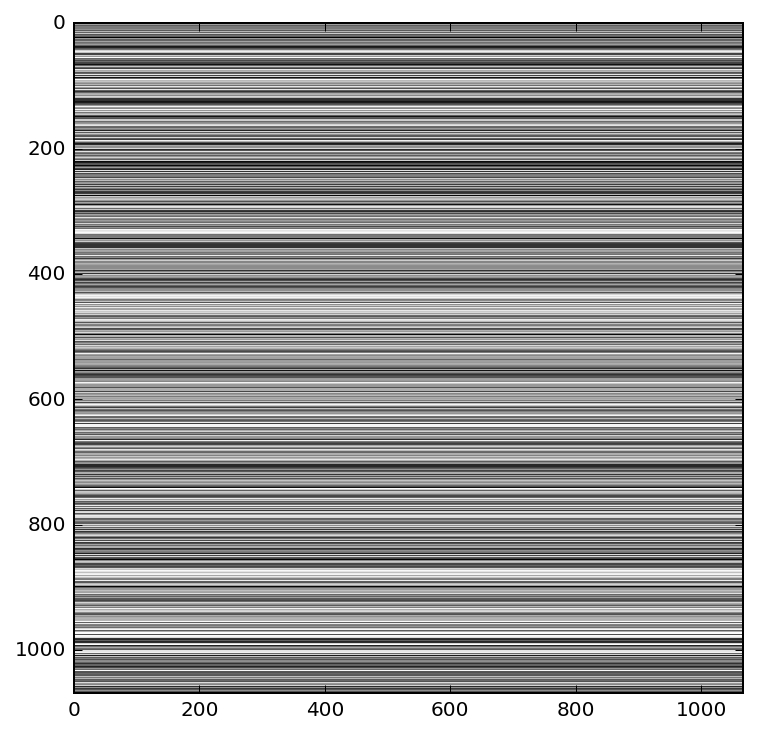

In [12]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(affinity='precomputed').fit(Sij)

finalK2 = len(af.cluster_centers_indices_)
print(finalK2)

AM = np.zeros((N,N), np.float64)
for i in range(N):            
    for j in range(N):            
        AM[i, j] = af.labels_[i]
            
plt.figure()
plt.imshow(AM, cmap='gray')
plt.show()

In [13]:
#finalK = 7
#eig_gmm = GaussianMixture(n_components=finalK, covariance_type='full', random_state=0)
#eig_gmm.fit(top_vecs)

final_hmms = []
final_nk = []
top_classes = eig_gmm.predict(top_vecs)
#top_classes = af.labels_
#finalK = finalK2
for i in range(finalK):    
    tmp1 = []
    num = 0
    tmp1_ls = []
    for j in range(N):
        if top_classes[j] == i:
            tmp1 += PN[j]
            tmp1_ls.append(len(PN[j]))
            num += 1
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag")
    hmm1.fit(tmp1, tmp1_ls)    
    final_hmms.append(hmm1)
    final_nk.append(num)    

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  a_lse = logsumexp(a, axis)


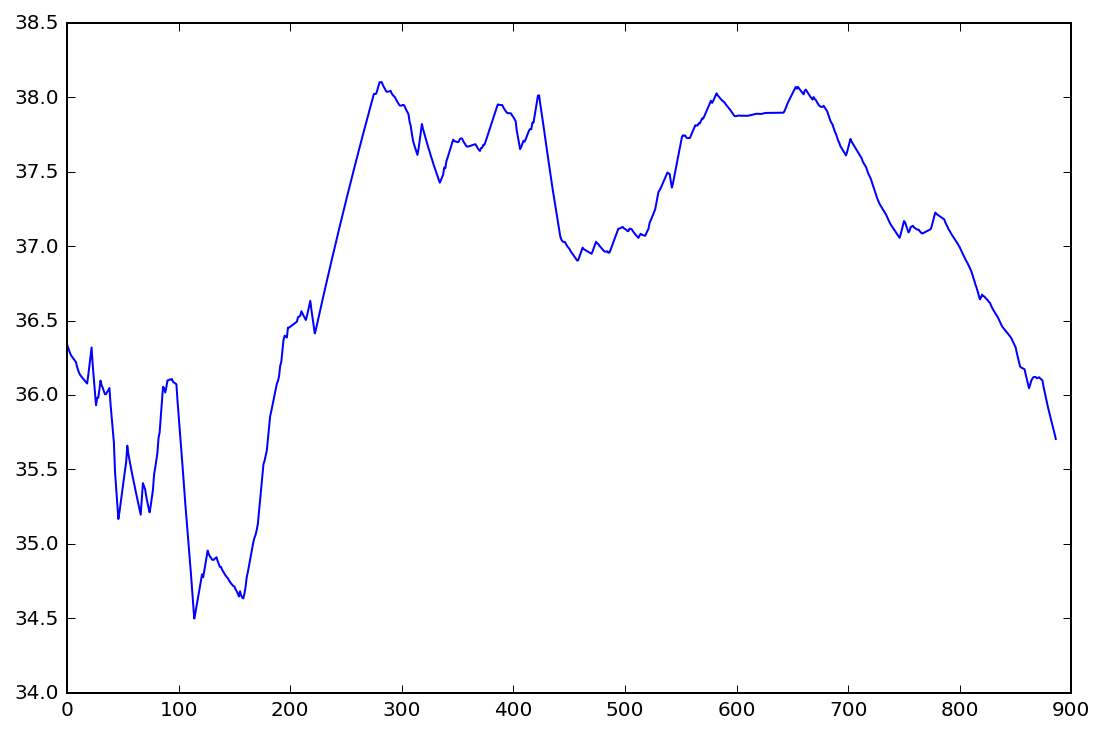

In [31]:
from hmmlearn.stats import _log_multivariate_normal_density_diag
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from hmmlearn.utils import log_mask_zero
from scipy.special import logsumexp

df_test = pd.read_csv("data_reception_test_left_object.csv")
df_test.drop([df_test.columns[0], "Rf"], inplace=True, axis=1)
#df_test = extend_set(df_test)
#df_test = extend_set(df_test)
#df_test = extend_set(df_test)

df2_test = df_test.drop([df_test.columns[0], df_test.columns[1]], axis=1)
df2_test = pd.DataFrame(scaler.transform(df2_test), columns=df_test.columns[2:])

df3_test = pd.DataFrame(bgmm.predict_proba(df2_test))
df3_test["time"] = df_test["time"]
df3_test["frame"] = df_test["frame"]
df3_test = df3_test.groupby(['time', 'frame']).agg('max')
df3_test.reset_index(inplace=True)

lattices = []

work_buffer = np.zeros(bgmm.n_components)

def my_forward_pass(hmm, fwdlattice, framelogprob, n_samples):
    n_samples_aa, n_components = framelogprob.shape    
    log_startprob = log_mask_zero(hmm.startprob_)
    log_transmat = log_mask_zero(hmm.transmat_)    
    if (n_samples == 1):
        for i in range(n_components):            
            fwdlattice[0, i] = log_startprob[i] + framelogprob[0, i]
    else:                    
        for j in range(n_components):
            for i in range(n_components):
                work_buffer[i] = fwdlattice[n_samples - 2, i] + log_transmat[i, j]            
            fwdlattice[n_samples - 1, j] = logsumexp(work_buffer) + framelogprob[0, j]
    return logsumexp(fwdlattice[n_samples - 1])

def calc_final_prob(samples):
    i_a = []
    i_b = []
    
    for i in range(finalK):                                
        lgg = _log_multivariate_normal_density_diag(check_array([samples[-1]]), final_hmms[i].means_, final_hmms[i]._covars_)        
        my_s = my_forward_pass(final_hmms[i], lattices[i], lgg, len(samples))
        act_s = my_s
        
        #act_s = final_hmms[i].score(samples)        
        #assert(np.allclose(my_s, act_s))
                        
        i_a.append(act_s)
        i_b.append(float(final_nk[i]) / float(N))        
        
    return scipy.special.logsumexp(a=i_a, b=i_b)

def calc_final_prob_i(samples, i):
    lgg = _log_multivariate_normal_density_diag(check_array([samples[-1]]), final_hmms[i].means_, final_hmms[i]._covars_)
    return my_forward_pass(final_hmms[i], lattices[i], lgg, len(samples))

TestPN = df3_test.drop(["time", "frame"], axis=1)
#TestPN = TestPN.head(1500)

for i in range(finalK):
    check_is_fitted(final_hmms[i], "startprob_")
    final_hmms[i]._check()
    lattices.append(np.zeros((len(TestPN), bgmm.n_components)))
                    
test_arr = []
scrs = []
scrs_raw = []
j = 1

for i in range(len(TestPN)):
    r = TestPN.iloc[i].ravel()
    test_arr.append(r)
    prb = calc_final_prob(test_arr)
    scrs.append(prb / j)    
    scrs_raw.append(prb)    
    j += 1
    
plt.figure()
plt.plot(scrs[int(seg_len * 1.5 * 10):])
#plt.plot(scrs)
plt.show()

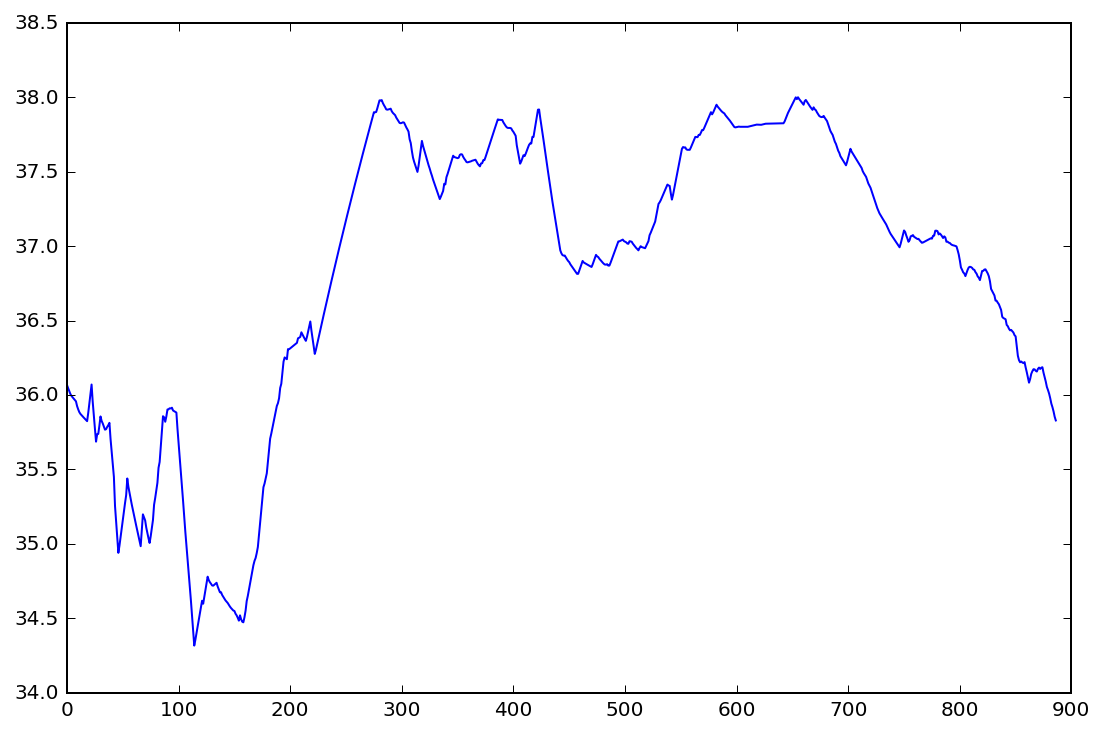

In [32]:
scrs3 = []

wnd = 1000

for i in range(len(TestPN)):    
    if i >= wnd:
        scrs3.append((scrs_raw[i] - scrs_raw[i - wnd + 1]) / float(wnd))
    elif i >= 1:
        scrs3.append((scrs_raw[i] - scrs_raw[0]) / (i + 1))
    else:
        scrs3.append(scrs_raw[0])
    
plt.figure()
#plt.plot(range(int(seg_len * 1.5 * 10), len(scrs3)), scrs3[int(seg_len * 1.5 * 10):])
#plt.plot(scrs3)
plt.plot(scrs3[int(seg_len * 1.5 * 10):])
plt.show()    

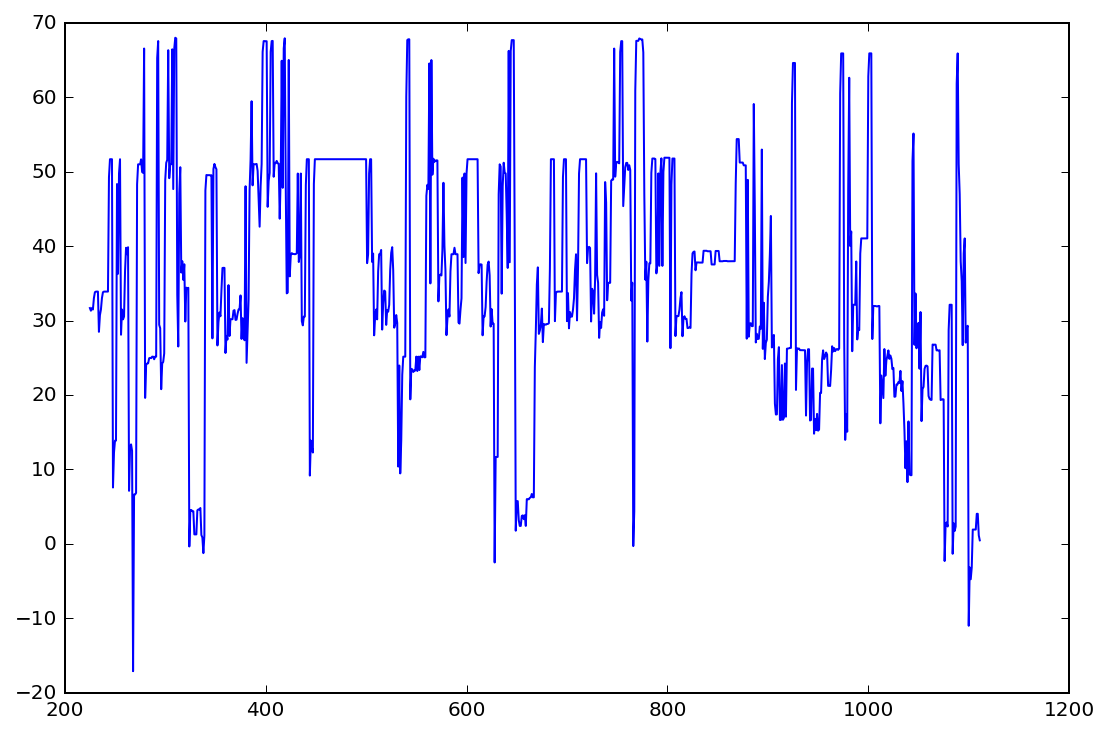

In [33]:
scrs2 = []

prev = 0

for i in range(len(TestPN)):    
    scrs2.append((scrs_raw[i] - prev) / (0 + 1))
    prev = scrs_raw[i]
    
plt.figure()
plt.plot(range(int(seg_len * 1.5 * 10), len(scrs2)), scrs2[int(seg_len * 1.5 * 10):])
plt.show()    

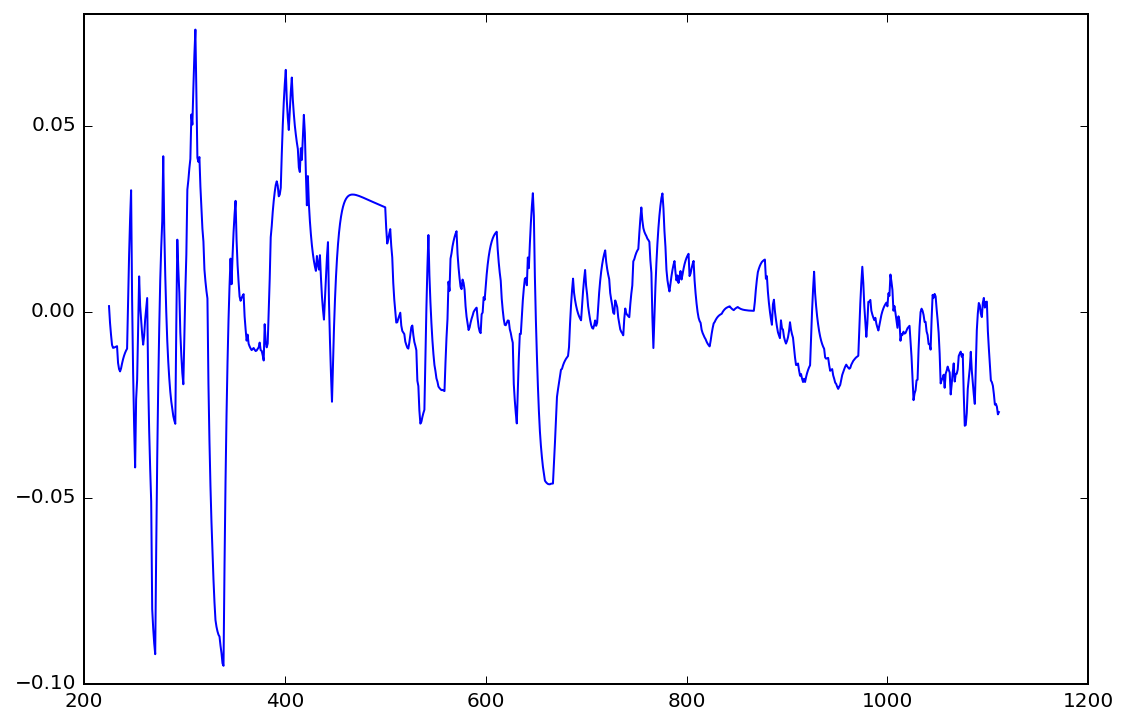

In [34]:
import traceback

Qt = 0
alpha = 0.2

first_frm = int(seg_len * 1.5 * 10)
#first_frm = 5000
first_frm_num = 0

qts = {}
qts_lst = []
frm_to_i = {}
for i in range(len(scrs)):
    if i == 0:
        Qt = scrs3[0]
    else:
        Qt = (1 - alpha) * Qt + alpha * (scrs3[i] - scrs3[i - 1])
        #Qt = (1 - alpha) * Qt + alpha * scrs2[i]
    #Qt = scrs2[i]    
    qts[df3_test.iloc[i]["frame"]] = Qt
    frm_to_i[df3_test.iloc[i]["frame"]] = i
    qts_lst.append(Qt)
    if i == first_frm:
        first_frm_num = df3_test.iloc[i]["frame"]
            
plt.figure()
plt.plot(range(first_frm, len(qts_lst)), qts_lst[first_frm:])
plt.show()

#cap = cv2.VideoCapture('Datasets/Pedestrian/test.avi')
#cap = cv2.VideoCapture('z3.avi')
#cap = cv2.VideoCapture('kitchen2.avi')
#cap = cv2.VideoCapture('Datasets/Crossroads1/test.avi')
cap = cv2.VideoCapture('reception_test_short_1.avi')
ok, frame = cap.read()
aspect = float(frame.shape[1]) / frame.shape[0]
cap.release()
#cap = cv2.VideoCapture('Datasets/Pedestrian/test.avi')
#cap = cv2.VideoCapture('z3.avi')
#cap = cv2.VideoCapture('kitchen2.avi')
#cap = cv2.VideoCapture('Datasets/Crossroads1/test.avi')
cap = cv2.VideoCapture('reception_test_short_1.avi')

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        frame = cv2.resize(frame, (int(240 * aspect), 240), interpolation = cv2.INTER_AREA)    
        fnum = cap.get(cv2.CAP_PROP_POS_FRAMES)    
        delay = 1
        if (fnum >= first_frm_num) and (fnum in qts):
            if qts[fnum] < -0.2:
                cv2.rectangle(frame, (0,0), (frame.shape[1], frame.shape[0]), (0,0,255), 10)
                delay = 0
                #print("frame", frm_to_i[fnum])
        cv2.imshow('frame', frame)        
        k = cv2.waitKey(delay) & 0xff        
        #if delay == 0:
        #    time.sleep(1)
        if k == 32:
            k = cv2.waitKey() & 0xff
        if k == 27:
            break
except Exception as e:    
    traceback.print_exc()

cap.release()
cv2.destroyAllWindows()